## 데이터 전처리

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f031851c490>)

In [3]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [4]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 150000


In [5]:
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [6]:
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

테스트용 리뷰 개수 : 50000


In [7]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [8]:
train_data.nunique()

id          150000
document    146182
label            2
dtype: int64

In [9]:
train_data.drop_duplicates(subset=['document'], inplace=True)

In [10]:
len(train_data)

146183

<AxesSubplot:>

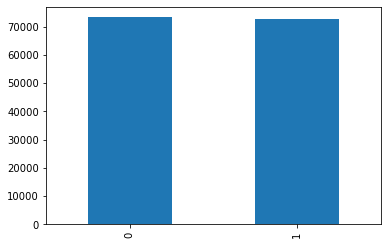

In [11]:
train_data['label'].value_counts().plot(kind = 'bar')

In [12]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


In [13]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [14]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [15]:
train_data.loc[train_data['document'].isnull()]

,id,document,label
25857,2172111,NaN,1


In [16]:
train_data = train_data.dropna()

In [17]:
train_data.loc[train_data['document'].isnull()]

,id,document,label


In [18]:
print(train_data.isnull().count())

id          146182
document    146182
label       146182
dtype: int64


In [19]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

/home/aiffel-dj62/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [20]:
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [21]:
train_data['document'] = train_data['document'].str.replace('^ +', "")

/home/aiffel-dj62/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [22]:
train_data['document'].replace("", np.nan, inplace = True)

In [23]:
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


In [24]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [25]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


In [26]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

/home/aiffel-dj62/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


전처리 후 테스트용 샘플의 개수 : 48852


/home/aiffel-dj62/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


## 토큰화

#### 형태소분석

In [27]:
from konlpy.tag import Mecab
mecab = Mecab()


# MeCab 단어 사전을 만들기 
# Hint : mecab.morphs()를 사용해서 형태소분석을 합니다.
def mecab_split(sentence):
    word = mecab.morphs(sentence)
    return word

X_train = []

for kor in train_data['document']:
    X_train.append(mecab_split(kor))

In [28]:
X_test = []

for kor in test_data['document']:
    X_test.append(mecab_split(kor))

In [29]:
X_train[0]

['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리']

#### 토큰화

In [30]:
# # 위에서 만든 (형태소 기반)단어장을 사용하여 토큰화

# def tokenize(corpus):  # corpus: Tokenized Sentence's List
    
#     tokenizer = tf.keras.preprocessing.text.Tokenizer(vocab_size, filters='', oov_token = 'OOV')
#     tokenizer.fit_on_texts(corpus)

#     tensor = tokenizer.texts_to_sequences(corpus)

#     tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')

#     return tensor, tokenizer


# mecab_tensor, mecab_tokenizer = tokenize(X_train)
# print(len(mecab_tokenizer.index_word))

In [31]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

#### keras tokenizer도 같은 역할
* 문자 데이터를 입력받아서 리스트의 형태로 변환
* 단어장 생성
* 딴어 인덱스 생성
* 띄어쓰기 기준(영어와 같은 교착어에 활용)
* Required before using texts_to_sequences or texts_to_matrix
  * texts_to_sequences() 메서드는 텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환

### 단어장 생성 후 비율 확인

### 희귀 단어 제거

In [32]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 49964
등장 빈도가 2번 이하인 희귀 단어의 수: 28321
단어 집합에서 희귀 단어의 비율: 56.68281162436954
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.4670433277952577


In [33]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 21645


In [34]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [35]:
# tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
# tokenizer.fit_on_texts(X_train)
# X_train = tokenizer.texts_to_sequences(X_train)
# X_test = tokenizer.texts_to_sequences(X_test)

In [36]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [37]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
print(drop_train)

[10, 2321, 2432, 4289, 6044, 6328, 7141, 7790, 9076, 9660, 9817, 9859, 11016, 11897, 12111, 12766, 15683, 16434, 16509, 16926, 16985, 17120, 17564, 18626, 18659, 19002, 19672, 20379, 21273, 23123, 24425, 24609, 26313, 27110, 28010, 28474, 29618, 30187, 30817, 34017, 34216, 34919, 37260, 39284, 40665, 40987, 42703, 42805, 45944, 47456, 48827, 48857, 48859, 49347, 50333, 50719, 51802, 53624, 54640, 55399, 55739, 56274, 56971, 57036, 58380, 59965, 61407, 61628, 61949, 62823, 63632, 63947, 64305, 64626, 65481, 67697, 68430, 69641, 71315, 71681, 72709, 73256, 74215, 74809, 75921, 76158, 76608, 77251, 77418, 78416, 78773, 79170, 79680, 79754, 80550, 81369, 83484, 85049, 85284, 85484, 86213, 87256, 87381, 87490, 87526, 88861, 88890, 89022, 89441, 91695, 91744, 93533, 93688, 94305, 96453, 99242, 99692, 100558, 102875, 103034, 103884, 104654, 104763, 106932, 106945, 107060, 107419, 109030, 110189, 111441, 111736, 113516, 114152, 114451, 114593, 115908, 115916, 117981, 118007, 118288, 118376, 11

In [38]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

145216
145216
48852
48852


리뷰의 최대 길이 : 95
리뷰의 평균 길이 : 16.3401415821948


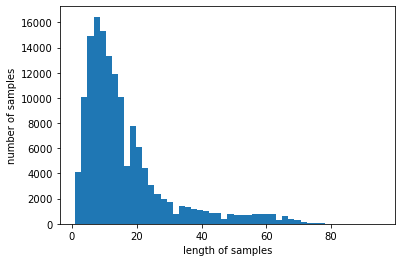

In [39]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [40]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [41]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 87.72518179814897


In [42]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [43]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [44]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [45]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [46]:
print(type(X_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [47]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1933/1937 [============================>.] - ETA: 0s - loss: 0.3894 - acc: 0.8241
Epoch 00001: val_acc improved from -inf to 0.84355, saving model to best_model.h5
1937/1937 [==============================] - 16s 8ms/step - loss: 0.3893 - acc: 0.8242 - val_loss: 0.3539 - val_acc: 0.8435
Epoch 2/15
1931/1937 [============================>.] - ETA: 0s - loss: 0.3230 - acc: 0.8604
Epoch 00002: val_acc improved from 0.84355 to 0.85412, saving model to best_model.h5
1937/1937 [==============================] - 16s 8ms/step - loss: 0.3230 - acc: 0.8605 - val_loss: 0.3366 - val_acc: 0.8541
Epoch 3/15
1932/1937 [============================>.] - ETA: 0s - loss: 0.2945 - acc: 0.8768
Epoch 00003: val_acc improved from 0.85412 to 0.86286, saving model to best_model.h5
1937/1937 [==============================] - 16s 8ms/step - loss: 0.2944 - acc: 0.8769 - val_loss: 0.3191 - val_acc: 0.8629
Epoch 4/15
1933/1937 [============================>.] - ETA: 0s - loss: 0.2722 - acc: 0.8876
Epoc

In [48]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 3s 2ms/step - loss: 0.3300 - acc: 0.8632

 테스트 정확도: 0.8632


## 네이버 영화리뷰 감정분석 코퍼스에 sentencepiece를 적용시킨 모델 학습하기


## 토큰화

In [49]:
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


## SPM 학습 모델 활용 인코딩

In [50]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/example.txt'

vocab_size = 10000

with open(temp_file, 'w') as f:
    for row in train_data['document']:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-r--r-- 1 aiffel-dj62 aiffel-dj62 417732  4월 21 03:38 korean_spm.model
-rw-r--r-- 1 aiffel-dj62 aiffel-dj62 189000  4월 21 03:38 korean_spm.vocab


In [51]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1164, 8, 429, 11, 1219, 8, 128, 13, 0]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다 ⁇ 


## 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정분석 모델을 재학습하기

In [52]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen = 30)

    return tensor, word_index, index_word

In [53]:
train_data[:3]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [54]:
tensor_train, word_index, index_word = sp_tokenize(s, train_data['document'])

In [55]:
print(tensor_train)

[[   0    0    0 ... 1884   56 1594]
 [   0    0    0 ... 7344  705  374]
 [   0    0    0 ... 6297 1644  298]
 ...
 [   0    0    0 ...   14 3275  109]
 [   0    0    0 ...  279  213  130]
 [   0    0    0 ...  361 5575    5]]


In [56]:
print(len(tensor_train[1]))

30


In [57]:
X_t = tensor_train
y_t = train_data['label']

In [58]:
tensor_test, word_index, index_word = sp_tokenize(s, test_data['document'])

In [59]:
print(len(tensor_test))

48852


In [60]:
X_tes = tensor_test
y_tes = test_data['label']

In [61]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [62]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [63]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [64]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_t, y_t, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1932/1939 [============================>.] - ETA: 0s - loss: 0.4034 - acc: 0.8153
Epoch 00001: val_acc improved from -inf to 0.84810, saving model to best_model.h5
1939/1939 [==============================] - 12s 6ms/step - loss: 0.4031 - acc: 0.8154 - val_loss: 0.3475 - val_acc: 0.8481
Epoch 2/15
1934/1939 [============================>.] - ETA: 0s - loss: 0.3249 - acc: 0.8600
Epoch 00002: val_acc improved from 0.84810 to 0.85601, saving model to best_model.h5
1939/1939 [==============================] - 12s 6ms/step - loss: 0.3249 - acc: 0.8600 - val_loss: 0.3361 - val_acc: 0.8560
Epoch 3/15
1931/1939 [============================>.] - ETA: 0s - loss: 0.3018 - acc: 0.8718
Epoch 00003: val_acc did not improve from 0.85601
1939/1939 [==============================] - 12s 6ms/step - loss: 0.3018 - acc: 0.8718 - val_loss: 0.3317 - val_acc: 0.8556
Epoch 4/15
1930/1939 [============================>.] - ETA: 0s - loss: 0.2861 - acc: 0.8800
Epoch 00004: val_acc improved from 0.85

In [65]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_tes, y_tes)[1]))

1527/1527 [==============================] - 3s 2ms/step - loss: 0.3396 - acc: 0.8572

 테스트 정확도: 0.8572


Step 4. 네이버 영화리뷰 감정분석 문제에 SentencePiece 적용해 보기

아마 여러분들은 네이버 영화리뷰 감정분석 태스크를 한 번쯤은 다루어 보았을 것입니다. 한국어로 된 corpus를 다루어야 하므로 주로 KoNLPy에서 제공하는 형태소 분석기를 사용하여 텍스트를 전처리해서 RNN 모델을 분류기로 사용했을 것입니다.

만약 이 문제에서 tokenizer를 sentencepiece로 바꾸어 다시 풀어본다면 더 성능이 좋아질까요? 비교해 보는 것도 흥미로울 것입니다.

* 네이버 영화리뷰 감정분석 코퍼스에 sentencepiece를 적용시킨 모델 학습하기

* 학습된 모델로 sp_tokenize() 메소드 구현하기

* 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정분석 모델을 재학습하기

* KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기

* (보너스) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

* Word Vector는 활용할 필요가 없습니다. 활용이 가능하지도 않을 것입니다.

* 머지않아 SentencePiece와 BERT 등의 pretrained 모델을 함께 활용하는 태스크를 다루게 될 것입니다.

## KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기

## 루브릭

1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?
* 코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었습니다.

2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?
* SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었습니다.

3. SentencePiece의 성능을 다각도로 비교분석하였는가?
* SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저(mecab)과 비교하였습니다. mecab을 사용한 모델과 SPM을 사용한 모델 모두 LSTM을 사용하였으며, 모드 정확도 85% 이상이 나왔습니다. 그러나 큰 차이가 없었기 때문에 의아했습니다.

## 회고

노드를 진행하며 작성했던 노트북을 1주일 이상 지난 시점에서 제출하였습니다. 막상 제출하려하니 지저분한 부분만 좀 수정하고 제출하자는 생각이 들었고, 이에 조금씩 꼬이기 시작하며 제대로 돌아가지 않는 부분이 생겼습니다. 이를 해결하는데 시간이 가장 많이 소요된것 같습니다. 노드 자체는 크게 어려운 부분은 없었지만, SPM이라는 새로운 토크나이저를 알게 되었고 이를 바탕으로 여러 토크나이저를 비교해볼 수 있어서 좋았습니다.